--- auto compile ---
--- auto compile complete ---
initiaze complete:
  solver: None
 ---- hyperparameter ----
  hyperparameter: tau_tilde=1.0
 ---- space ----
  space: nx=1000, dx=0.0010, Lx=1.0
 ---- velocity ----
  velocity: nv=200, dv=0.1005, v_max=10.0
 ---- time ----
  time: nt=101, dt=0.0005, T_total=0.05
  dtype: torch.float64
  device: cuda, GPU name: NVIDIA GeForce RTX 3070 Laptop GPU
--- compile cuSOLVER ---


Detected CUDA files, patching ldflags
Emitting ninja build file build/build.ninja...
/home/arlm/workspace/venv/lib/python3.12/site-packages/torch/utils/cpp_extension.py:2356: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module gtsv_batch...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.
--- compile CUDA fused implicit backend ---


Loading extension module gtsv_batch...
Detected CUDA files, patching ldflags
Emitting ninja build file build/build.ninja...
Building extension module implicit_fused...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.
--- fused CUDA backend loaded ---
--- compile LO block-tridiag backend ---


Loading extension module implicit_fused...
NoneType: None
Detected CUDA files, patching ldflags
Emitting ninja build file build/build.ninja...
Building extension module lo_blocktridiag...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module lo_blocktridiag...
NoneType: None


ninja: no work to do.
--- LO block-tridiag backend loaded ---
--- Convergence Test Start ---
--- tau_tilde: 0.005 ---
--- HOLO ---


Progress: 100%|███████████████████████████████████████████████████████| 101/101 [00:09<00:00, 10.74it/s]


--- PICARD ---


Progress: 100%|██████████████████████████████████████████████████████| 101/101 [00:00<00:00, 379.03it/s]


--- tau_tilde: 0.0005 ---
--- HOLO ---


Progress: 100%|███████████████████████████████████████████████████████| 101/101 [00:09<00:00, 10.91it/s]


--- PICARD ---


Progress: 100%|██████████████████████████████████████████████████████| 101/101 [00:00<00:00, 191.94it/s]


--- tau_tilde: 5e-05 ---
--- HOLO ---


Progress: 100%|███████████████████████████████████████████████████████| 101/101 [00:09<00:00, 10.92it/s]


--- PICARD ---


Progress: 100%|███████████████████████████████████████████████████████| 101/101 [00:02<00:00, 48.32it/s]


--- tau_tilde: 5e-06 ---
--- HOLO ---


Progress: 100%|███████████████████████████████████████████████████████| 101/101 [00:09<00:00, 10.90it/s]


--- PICARD ---


Progress: 100%|███████████████████████████████████████████████████████| 101/101 [00:09<00:00, 10.71it/s]


--- tau_tilde: 5e-07 ---
--- HOLO ---


Progress: 100%|███████████████████████████████████████████████████████| 101/101 [00:09<00:00, 10.85it/s]


--- PICARD ---


Progress: 100%|███████████████████████████████████████████████████████| 101/101 [00:10<00:00,  9.46it/s]


--- tau_tilde: 5e-08 ---
--- HOLO ---


Progress: 100%|███████████████████████████████████████████████████████| 101/101 [00:06<00:00, 16.12it/s]


--- PICARD ---


Progress: 100%|█████████████████████████████████████████████████████| 101/101 [00:00<00:00, 1400.27it/s]


--- Convergence Test Completed ---
ベンチマーク結果を保存: Conv_bench.pkl  (0.24 MB)
収束性テストの図を保存: Conv_bench.png


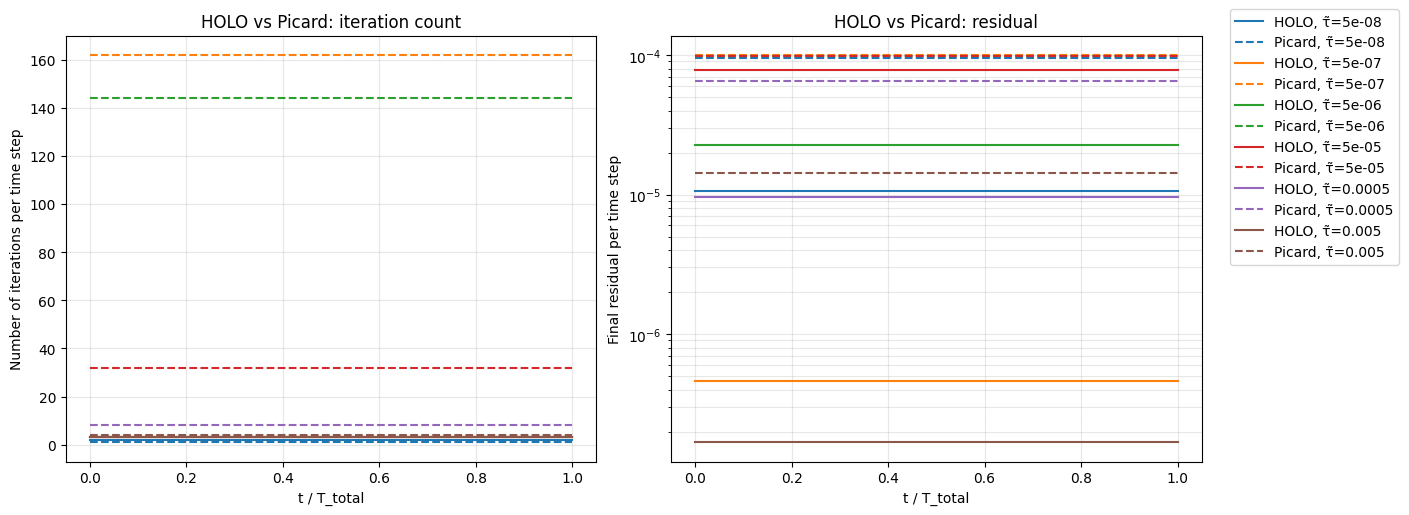

In [1]:
%run kineticEQ/tests/benchmarks/convergence_test.py --nv 200 --nx 1000 --picard_tol 1e-4 --ho_tol 1e-4 --lo_tol 1e-4

In [3]:
import pickle
from pprint import pprint

with open("Conv_bench.pkl", "rb") as f:
    data = pickle.load(f)

print("keys:", data.keys())
print("\n=== meta ===")
pprint(data["meta"])

results = data["results"]
print("\n=== results 概要 ===")
print("型:", type(results))
print("要素数:", len(results))

print("\n=== 先頭 5 要素 ===")
for r in results[:5]:
    pprint(r)

import pickle
from collections import Counter

with open("Conv_bench.pkl", "rb") as f:
    data = pickle.load(f)

results = data["results"]

print("全レコード数:", len(results))

cnt = Counter((r["scheme"], float(r["tau_tilde"])) for r in results)
print("\n=== (scheme, tau_tilde) ごとの件数 ===")
for key, v in sorted(cnt.items(), key=lambda x: (x[0][0], x[0][1])):
    print(key, "->", v)

import pickle
from collections import defaultdict
import math

with open("Conv_bench.pkl", "rb") as f:
    data = pickle.load(f)

results = data["results"]

stats = defaultdict(lambda: {"ho_iter": [], "pi_iter": [], "ho_res": [], "pi_res": []})

for r in results:
    tau = float(r["tau_tilde"])
    if r["scheme"] == "holo":
        stats[tau]["ho_iter"].append(r["ho_iter"])
        stats[tau]["ho_res"].append(r["ho_residual"])
    elif r["scheme"] == "implicit_picard":
        stats[tau]["pi_iter"].append(r["picard_iter"])
        stats[tau]["pi_res"].append(r["picard_residual"])

for tau in sorted(stats.keys()):
    s = stats[tau]
    print(f"\nτ̃ = {tau:g}")
    if s["ho_iter"]:
        print("  HOLO:  iter(min/max) =", min(s["ho_iter"]), max(s["ho_iter"]),
              "  res(min/max) =", min(s["ho_res"]), max(s["ho_res"]))
    if s["pi_iter"]:
        print("  Picard: iter(min/max) =", min(s["pi_iter"]), max(s["pi_iter"]),
              "  res(min/max) =", min(s["pi_res"]), max(s["pi_res"]))

keys: dict_keys(['meta', 'results'])

=== meta ===
{'device': 'cuda',
 'dtype': 'torch.float64',
 'hostname': 'arlm-ASUS-TUF-Gaming-A15-FA506QR',
 'saved_at': '2025-11-24T15:49:04',
 'solver': None,
 'torch_version': '2.7.1+cu126'}

=== results 概要 ===
型: <class 'list'>
要素数: 1212

=== 先頭 5 要素 ===
{'ho_iter': 3,
 'ho_residual': tensor(1.6764e-07, device='cuda:0'),
 'lo_iter_list': [10, 10, 10],
 'lo_residual': [8.230868647990386e-05,
                 8.945191587866885e-05,
                 8.943187672094677e-05],
 'scheme': 'holo',
 'step': 0,
 'tau_tilde': 0.005,
 'time': 0.0}
{'ho_iter': 3,
 'ho_residual': tensor(1.6764e-07, device='cuda:0'),
 'lo_iter_list': [10, 10, 10],
 'lo_residual': [8.230868647990386e-05,
                 8.945191587866885e-05,
                 8.943187672094677e-05],
 'scheme': 'holo',
 'step': 1,
 'tau_tilde': 0.005,
 'time': 0.0005}
{'ho_iter': 3,
 'ho_residual': tensor(1.6764e-07, device='cuda:0'),
 'lo_iter_list': [10, 10, 10],
 'lo_residual': [8.2308686479